"""5가지 요구사항 : 

1. 웹크롤링을 통하여 관심주제에 대한 감정분석 데이터를 수집하고 수집한 내용과 코드 설명을 병행하여 제시하세요

   *참조 : 7주차 실습 코드 3. 종합실습 코드를 참조하여 새롭게 크롤링

2. Konlpy 또는 정규표현식(re) 라이브러리를 이용하여 위에서 수집한 감정분석에 대한 택스트 데이터에 대하여 전처리를 하고 적용한 절차와 코드를 설명하세요. 

3. 2항의 전처리 결과를 문서별 코퍼스를 토큰화하여 DTM, TF-IDF에 의한 대략적인 키워드에 대한 빈도를 분석하고 결과를 설명하세요. 

4. 위에서 처리된 내용을 기초로 로지스틱 회귀분석에 의한 감정분석을 실시하고 계수들의 웨이트를 이용한 긍정과 부정의 키워드를 시각화하여 보여주고 코드와 결과를 설명하세요.

5. 위에서 분석한 결과를 기초로 빈도수와 긍정 부정 키워드의 관계, 자료의 불균형과 모형의 예측 정확도의 관계에 대하여 위에서 분석한 사례를 들어 논하세요.   

"""
문제의식: 영화 평가에 있어 시대에 따른 표현법의 차이에 대한 의문
절차 1: 2014 ~ 2023 각 연도별 흥행 상위 10위 영화 목록을 구한다.
절차 2: 2019 ~ 2023 개봉영화와 2014 ~ 2018 개봉영화의 별점과 평가를 수집한다.
절차 3: 각각의 코퍼스를 train set과 test set으로 구분한다.
절차 4: 2019 ~ 2023 개봉영화 train set으로 훈련한 모델을 두 개의 test set에 적용하여 정확도를 비교한다
절차 5: 2014 ~ 2013 개봉영화 train set으로 훈련한 모델을 두 개의 test set에 적용하여 정확도를 비교한다
예측 결과1: 시의 적절한 훈련 데이터 수집의 필요성에 대해 할 수 있다.
예측 결과2: 시대에 따른 영화 평가 방식의 표현법 차이를 수치화 할 수 있다.

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup as bs
from urllib.request import Request, urlopen
import pandas as pd
import time
import requests
import json
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from sklearn.feature_extraction.text import TfidfTransformer
from collections import Counter

# 1. 데이터 크롤링

In [2]:
#기간 내 전체 영화 대상으로는 크롤링 시간이 장시간 소모되어 대상변경
#영진위 api로부터 각 년도간 영화정보 저장
# start_year = 2014
# end_year = 2023
# api_key = '1b7d7d5da614bb2d2974f2a6ca95cded'
# raw_df = pd.DataFrame(index=range(0,1), columns = ['moiveListResult','moiveList'])

# for page_num in range(1,1469):
#     api_url = f'http://kobis.or.kr/kobisopenapi/webservice/rest/movie/searchMovieList.json?key={api_key}&openStartDt={start_year}&openEndDt={end_year}&curPage={page_num}'
#     request = Request(api_url)
#     response = urlopen(request).read()
#     response_json = json.loads(response)
#     response_df = pd.DataFrame(response_json['movieListResult']['movieList'])
#     raw_df = pd.concat([raw_df, response_df], axis=0)
#     print(str(page_num) + '페이지 조회했습니다')

In [3]:
#수동으로 구한 연도별 흥행성적 top 10 영화 정보 Import
movie_ranking_df = pd.read_csv('movie_ranking.csv')

In [4]:
movie_ranking_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   영화명     102 non-null    object
 1   개봉일     102 non-null    object
dtypes: object(2)
memory usage: 1.7+ KB


In [5]:
movie_ranking_df['개봉일'] = movie_ranking_df['개봉일'].str[:4].astype(int)

In [6]:
movie_ranking_df.head()

,영화명,개봉일
0,명량,2014
1,겨울왕국,2014
2,인터스텔라,2014
3,해적: 바다로 간 산적,2014
4,수상한 그녀,2014


In [7]:
df_smaller_than_2019 = movie_ranking_df[movie_ranking_df['개봉일'] < 2019]
df_greater_or_equal_to_2019 = movie_ranking_df[movie_ranking_df['개봉일'] >= 2019]

In [8]:
older_movie_names = df_smaller_than_2019['영화명'].tolist()
newer_movie_names = df_greater_or_equal_to_2019['영화명'].tolist()

In [9]:
print(older_movie_names[:5])
print(newer_movie_names[:5])

['명량', '겨울왕국', '인터스텔라', '해적: 바다로 간 산적', '수상한 그녀']
['극한직업', '어벤져스: 엔드게임', '겨울왕국 2', '알라딘', '기생충']


In [10]:
data = []
times = 0
for movie_name in older_movie_names:
    # 드라이버 사용해서 크롬 열기
    driver = webdriver.Chrome('chromedriver_mac_arm64/chromedriver')
    driver.get(f'https://search.naver.com/search.naver?where=nexearch&sm=top_hty&fbm=0&ie=utf8&query=영화+{movie_name}+평점')
    time.sleep(15)
    driver.execute_script("window.scrollTo(0, 800)")
    time.sleep(2)

    # 스크롤용 경로 생성
    x_path = "/html/body/div[3]/div[2]/div/div[1]/div[2]/div[2]/div[2]/div/div[2]/div[6]"
    try:
        to_scroll = driver.find_element_by_xpath(x_path)
        
    except Exception as e:
        print(f"An error occurred: {str(e)} for {movie_name}")
        continue
        
    # 별점과 코멘트 초기화
    counts = 0
    movie_comments = []
    movie_ratings = []

    while True:

        all_contents = driver.find_elements(By.CSS_SELECTOR, "div.lego_review_list._scroller")

        flag = False  # Flag variable to track if break has already been executed

        for content in all_contents:
            li_comments = content.find_elements(By.CSS_SELECTOR, "span.desc._text")
            li_ratings = content.find_elements(By.CSS_SELECTOR, "div.area_text_box")
            for li_comment in li_comments[counts:]:
                movie_comments.append(li_comment.text)

            for li_rating in li_ratings[counts:]:
                rating_value = li_rating.get_attribute("textContent").replace("별점(10점 만점 중)", "").strip()
                movie_ratings.append(int(rating_value))

        if len(movie_comments) == counts:
            flag = True  # Set flag to True if the break statement is executed
            break

        if flag:
            print('종료')
            break
        counts = len(movie_comments)
        times += 1
        print(str(movie_name) +' ' + str(times) + ' 회 실행했습니다')

        driver.execute_script("arguments[0].scrollTop = arguments[0].scrollHeight", to_scroll)
        time.sleep(3)

        
    if len(movie_comments) == 0:
        continue
    driver.quit()
    # 영화정보로 딕셔너리 생성
    movie_data = {
        'movieName': [movie_name] * len(movie_comments),
        'comments': movie_comments,
        'ratings': movie_ratings
    }

    # data 리스트에 정보추가
    data.extend(pd.DataFrame(movie_data).to_dict('records'))

older_movie_df = pd.DataFrame(data)


명량1 회 실행했습니다
명량2 회 실행했습니다
명량3 회 실행했습니다
명량4 회 실행했습니다
명량5 회 실행했습니다
명량6 회 실행했습니다
명량7 회 실행했습니다
명량8 회 실행했습니다
명량9 회 실행했습니다
명량10 회 실행했습니다
명량11 회 실행했습니다
명량12 회 실행했습니다
명량13 회 실행했습니다
명량14 회 실행했습니다
명량15 회 실행했습니다
명량16 회 실행했습니다
명량17 회 실행했습니다
명량18 회 실행했습니다
명량19 회 실행했습니다
명량20 회 실행했습니다
명량21 회 실행했습니다
명량22 회 실행했습니다
명량23 회 실행했습니다
명량24 회 실행했습니다
명량25 회 실행했습니다
명량26 회 실행했습니다
명량27 회 실행했습니다
명량28 회 실행했습니다
명량29 회 실행했습니다
명량30 회 실행했습니다
명량31 회 실행했습니다
인터스텔라32 회 실행했습니다
인터스텔라33 회 실행했습니다
인터스텔라34 회 실행했습니다
인터스텔라35 회 실행했습니다
인터스텔라36 회 실행했습니다
인터스텔라37 회 실행했습니다
인터스텔라38 회 실행했습니다
인터스텔라39 회 실행했습니다
인터스텔라40 회 실행했습니다
인터스텔라41 회 실행했습니다
인터스텔라42 회 실행했습니다
인터스텔라43 회 실행했습니다
인터스텔라44 회 실행했습니다
인터스텔라45 회 실행했습니다
인터스텔라46 회 실행했습니다
인터스텔라47 회 실행했습니다
인터스텔라48 회 실행했습니다
인터스텔라49 회 실행했습니다
인터스텔라50 회 실행했습니다
인터스텔라51 회 실행했습니다
인터스텔라52 회 실행했습니다
인터스텔라53 회 실행했습니다
인터스텔라54 회 실행했습니다
인터스텔라55 회 실행했습니다
인터스텔라56 회 실행했습니다
인터스텔라57 회 실행했습니다
인터스텔라58 회 실행했습니다
인터스텔라59 회 실행했습니다
인터스텔라60 회 실행했습니다
인터스텔라61 회 실행했습니다
인터스텔라62 회 실행했습니다
해적: 바다로 간 산적63 회 실행했습니다
해적: 바다로 간 산적64 회 실행했습니다


In [11]:
data = []
times = 0
for movie_name in newer_movie_names:
    # 드라이버 사용해서 크롬 열기
    driver = webdriver.Chrome('chromedriver_mac_arm64/chromedriver')
    driver.get(f'https://search.naver.com/search.naver?where=nexearch&sm=top_hty&fbm=0&ie=utf8&query=영화+{movie_name}+평점')
    time.sleep(15)
    driver.execute_script("window.scrollTo(0, 800)")
    time.sleep(2)

    # 스크롤용 경로 생성
    x_path = "/html/body/div[3]/div[2]/div/div[1]/div[2]/div[2]/div[2]/div/div[2]/div[6]"
    try:
        to_scroll = driver.find_element_by_xpath(x_path)
        
    except Exception as e:
        print(f"An error occurred: {str(e)} for {movie_name}")
        continue
        
    # 별점과 코멘트 초기화
    counts = 0
    movie_comments = []
    movie_ratings = []

    while True:

        all_contents = driver.find_elements(By.CSS_SELECTOR, "div.lego_review_list._scroller")

        flag = False  # Flag variable to track if break has already been executed

        for content in all_contents:
            li_comments = content.find_elements(By.CSS_SELECTOR, "span.desc._text")
            li_ratings = content.find_elements(By.CSS_SELECTOR, "div.area_text_box")
            for li_comment in li_comments[counts:]:
                movie_comments.append(li_comment.text)

            for li_rating in li_ratings[counts:]:
                rating_value = li_rating.get_attribute("textContent").replace("별점(10점 만점 중)", "").strip()
                movie_ratings.append(int(rating_value))

        if len(movie_comments) == counts:
            flag = True  # Set flag to True if the break statement is executed
            break

        if flag:
            print('종료')
            break
        counts = len(movie_comments)
        times += 1
        print(str(movie_name) + ' ' + str(times) + ' 회 실행했습니다')

        driver.execute_script("arguments[0].scrollTop = arguments[0].scrollHeight", to_scroll)
        time.sleep(3)

        
    if len(movie_comments) == 0:
        continue
    driver.quit()
    # 영화정보로 딕셔너리 생성
    movie_data = {
        'movieName': [movie_name] * len(movie_comments),
        'comments': movie_comments,
        'ratings': movie_ratings
    }

    # data 리스트에 정보추가
    data.extend(pd.DataFrame(movie_data).to_dict('records'))


newer_movie_df = pd.DataFrame(data)


극한직업1 회 실행했습니다
극한직업2 회 실행했습니다
극한직업3 회 실행했습니다
극한직업4 회 실행했습니다
극한직업5 회 실행했습니다
극한직업6 회 실행했습니다
극한직업7 회 실행했습니다
극한직업8 회 실행했습니다
극한직업9 회 실행했습니다
극한직업10 회 실행했습니다
극한직업11 회 실행했습니다
극한직업12 회 실행했습니다
극한직업13 회 실행했습니다
극한직업14 회 실행했습니다
극한직업15 회 실행했습니다
극한직업16 회 실행했습니다
극한직업17 회 실행했습니다
극한직업18 회 실행했습니다
극한직업19 회 실행했습니다
극한직업20 회 실행했습니다
극한직업21 회 실행했습니다
극한직업22 회 실행했습니다
극한직업23 회 실행했습니다
극한직업24 회 실행했습니다
극한직업25 회 실행했습니다
극한직업26 회 실행했습니다
극한직업27 회 실행했습니다
극한직업28 회 실행했습니다
극한직업29 회 실행했습니다
극한직업30 회 실행했습니다
극한직업31 회 실행했습니다
어벤져스: 엔드게임32 회 실행했습니다
어벤져스: 엔드게임33 회 실행했습니다
어벤져스: 엔드게임34 회 실행했습니다
어벤져스: 엔드게임35 회 실행했습니다
어벤져스: 엔드게임36 회 실행했습니다
어벤져스: 엔드게임37 회 실행했습니다
어벤져스: 엔드게임38 회 실행했습니다
어벤져스: 엔드게임39 회 실행했습니다
어벤져스: 엔드게임40 회 실행했습니다
어벤져스: 엔드게임41 회 실행했습니다
어벤져스: 엔드게임42 회 실행했습니다
어벤져스: 엔드게임43 회 실행했습니다
어벤져스: 엔드게임44 회 실행했습니다
어벤져스: 엔드게임45 회 실행했습니다
어벤져스: 엔드게임46 회 실행했습니다
어벤져스: 엔드게임47 회 실행했습니다
어벤져스: 엔드게임48 회 실행했습니다
어벤져스: 엔드게임49 회 실행했습니다
어벤져스: 엔드게임50 회 실행했습니다
어벤져스: 엔드게임51 회 실행했습니다
어벤져스: 엔드게임52 회 실행했습니다
어벤져스: 엔드게임53 회 실행했습니다
어벤져스: 엔드게임54 회 실행했습니다
어벤져스: 엔

In [234]:
#csv 파일로 데이터 백업
newer_movie_df.to_csv('newer_movie_df.csv')
older_movie_df.to_csv('older_movie_df.csv')

In [235]:
#정규표현식으로 데이터 1차 처리
import re
older_movie_df['comments'] = older_movie_df['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
newer_movie_df['comments'] = newer_movie_df['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

/var/folders/yg/9yd93xf50jd9_2hqv9d_xkl40000gn/T/ipykernel_92582/4229542447.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  older_movie_df['comments'] = older_movie_df['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
/var/folders/yg/9yd93xf50jd9_2hqv9d_xkl40000gn/T/ipykernel_92582/4229542447.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  newer_movie_df['comments'] = newer_movie_df['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [236]:
#별점에 따른 긍정/부정 분리
older_movie_df['PN'] = older_movie_df['ratings'].apply(lambda rating: 1 if rating >= 6 else 0)
newer_movie_df['PN'] = newer_movie_df['ratings'].apply(lambda rating: 1 if rating >= 6 else 0)

In [237]:
newer_movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14005 entries, 0 to 14004
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   movieName  14005 non-null  object
 1   comments   14005 non-null  object
 2   ratings    14005 non-null  int64 
 3   PN         14005 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 437.8+ KB


In [238]:
#stopwords 구성
#불용어 사전 출처 https://www.ranks.nl/stopwords/korean
stop_words = []
with open(stop_words_txt) as f:
    lines = f.readlines()

stop_words = [line.rstrip('\n') for line in lines]
print(stop_words[:5])

['아', '휴', '아이구', '아이쿠', '아이고']


In [239]:
from konlpy.tag import Mecab

In [240]:
mecab = Mecab()

In [241]:
older_movie_df.head()

,movieName,comments,ratings,PN
0,명량,그냥 뭐 애국심으로 보는 재미인듯,8,1
1,명량,영상과 연출력은 대단하다,8,1
2,명량,와 이런 영화를 보고도 엄청 재밌다고 하다니 보는 내내 어처구니가 없었구먼 진짜 한...,1,0
3,명량,아는 만큼 보이고 느낄 수 있는 영화 이 영화를 단순 국뽕영화라고 취급하는 사람들은...,10,1
4,명량,어벤져스한테 따라잡힐 준비해라,1,0


In [242]:
older_tokens ,older_corpus = [],[]
for comment in older_movie_df['comments']:
    temp_X = mecab.morphs(comment) # 토큰화
    temp_X = [word for word in temp_X if not word in stop_words] # 불용어 제거
    older_tokens.append(temp_X)
    older_corpus.append(' '.join(temp_X))

In [243]:
newer_tokens ,newer_corpus = [],[]
for comment in newer_movie_df['comments']:
    temp_X = mecab.morphs(comment) # 토큰화
    temp_X = [word for word in temp_X if not word in stop_words] # 불용어 제거
    newer_tokens.append(temp_X)
    newer_corpus.append(' '.join(temp_X))

In [245]:
#오래된 영화 긍정/부정 토큰 저장
p_older_tokens, n_older_tokens = [], []

for i, token in enumerate(older_tokens):
    if older_movie_df['PN'].values[i] == 1:  
        p_older_tokens.append(token)
    else :
        n_older_tokens.append(token)

print(n_older_tokens)

[['영화', '보', '고', '도', '엄청', '재밌', '다고', '다니', '보', '는', '내내', '어처구니', '없', '었', '구먼', '진짜', '한국', '관객', '영화', '수준', '높여야', '되', '는', '거', '냐', '인간', '적'], ['어벤져스', '한테', '잡힐', '준비', '해라'], ['재미있', '긴', '억지', '스럽', '지', '않', '싶', '네요', '당시', '조총', '살상', '거리', '최대', '사거리', '도', '안', '되', '었', '는데', '흔들리', '는', '배', '안', '저격', '는', '거', '수차례', '백병전', '했', '음', '도', '배안', '병사', '대부분', '말짱', '한', '감동', '재미', '무리수', '둔', '아닌가', '싶'], ['영화', '말', '되', '는', '은', '순신', '존재', '뿐', '다', '주인공', '역사', '적', '인', '물', '아닌', '가상', '인물', '었', '다면', '영화', '시작', '끝', '모든', '말', '되', '는', '부분', '단', '도', '없', '다', '감독', '은', '이순신', '뒤', '숨', '어서', '표', '팔아먹', '겠', '다고', '든', '다'], ['이순신', '기념', '며', '좋', '은', '영화', '더', '나오', '길'], ['재밌', '어요', '가족', '이랑', '보', '기', '좋', '은', '영화', '인', '같', '아요', '대', '였'], ['감독', '스케일', '장난', '다'], ['영화', '자체', '는', '그랬음'], ['꿀', '잼', '꿀', '잼', '랄', 'ㄹ', '랄', '랄', '랄', '룰', '룰'], ['서', '많이', '듣', '고', '보', '았', '던', '내용', '라'], ['기대', '보다', '별로', '였', '다', '이순신', '장군',

In [246]:
#최신 영화 긍정/부정 토큰 저장
p_newer_tokens, n_newer_tokens = [], []

for i, token in enumerate(newer_tokens):
    if newer_movie_df['PN'].values[i] == 1: 
        p_newer_tokens.append(token)
    else :
        n_newer_tokens.append(token)

print(n_newer_tokens)
print(p_newer_tokens)

[['수준', '낮', '아서', '재미없', 'ㅠㅠ'], ['킬링', '타임', '용', '입니다'], ['재미없', '습니', '디', '예상', '가능', '고', '유치', '한', '반전', '반복'], ['전', '유치', '했', '음'], ['이게', '재밌', '음', '유치', '함', '좋', '는', '사람', '만보', '샘'], ['이게', '재밌', '음', '유치', '함', '좋', '는', '사람', '만보', '샘'], [], ['어벤져스', '너무', '실망', '햇', '어요', '앞', '꺼', '만', '생각', '해', '재미', '잇', '겟', '다', '싶', '보', '러', '갓', '는데', '마지막', '어벤져스', '대', '실망', '햇', '어요', 'ㅜㅜㅜㅜ', '우째', '영화', '보', '러', '갈', '마다', '실패', '보', '는지', '이제', '영화', '보', '러', '기', '두렵', '고', '무섭', '네요', 'ㅎㅎㅎ'], ['최고', '영화', '입니다', '손', '떨리', '네요'], ['랫', '음아', '이언', '맨', '해라'], ['이거', '보', '면서', '우', '는', '사람', '뭐', '지'], ['정서', '는', '맞', '지', '않', '는', '허리', '우드', '전형'], ['아쉬움', '편', '보다', '박진감', '떨어짐', '솔직히', '기대', '만큼', '재미', '없', '었', '음', '영상미', '도', '생각', '보다', '화려', '한', '느낌', '없', '고', '되려', '단조로운', '느낌', '었', '고', '앨', '비중', '적', '어서', '아쉬웠', '음'], ['기대', '많이', '해서', '그런지', '실망', '스러웠', '어요'], ['가볍', '게', '보', '기', '좋', '은', '팝콘', '영화'], [], ['진짜', '노', '잼', '에요', 'ㅠ진짜재미없다길래'

In [247]:
from sklearn.feature_extraction.text import CountVectorizer
import gensim

In [248]:
n_older_corpus, p_older_corpus = [],[]
for tokens in p_older_tokens:
    for token in tokens:
        p_older_corpus.append(''.join(token))
for tokens in n_older_tokens:
    for token in tokens:
        n_older_corpus.append(''.join(token))
p1_older_corpus = ' '.join(p_older_corpus).split()
n1_older_corpus = ' '.join(n_older_corpus).split()
print(n1_older_corpus)

['영화', '보', '고', '도', '엄청', '재밌', '다고', '다니', '보', '는', '내내', '어처구니', '없', '었', '구먼', '진짜', '한국', '관객', '영화', '수준', '높여야', '되', '는', '거', '냐', '인간', '적', '어벤져스', '한테', '잡힐', '준비', '해라', '재미있', '긴', '억지', '스럽', '지', '않', '싶', '네요', '당시', '조총', '살상', '거리', '최대', '사거리', '도', '안', '되', '었', '는데', '흔들리', '는', '배', '안', '저격', '는', '거', '수차례', '백병전', '했', '음', '도', '배안', '병사', '대부분', '말짱', '한', '감동', '재미', '무리수', '둔', '아닌가', '싶', '영화', '말', '되', '는', '은', '순신', '존재', '뿐', '다', '주인공', '역사', '적', '인', '물', '아닌', '가상', '인물', '었', '다면', '영화', '시작', '끝', '모든', '말', '되', '는', '부분', '단', '도', '없', '다', '감독', '은', '이순신', '뒤', '숨', '어서', '표', '팔아먹', '겠', '다고', '든', '다', '이순신', '기념', '며', '좋', '은', '영화', '더', '나오', '길', '재밌', '어요', '가족', '이랑', '보', '기', '좋', '은', '영화', '인', '같', '아요', '대', '였', '감독', '스케일', '장난', '다', '영화', '자체', '는', '그랬음', '꿀', '잼', '꿀', '잼', '랄', 'ㄹ', '랄', '랄', '랄', '룰', '룰', '서', '많이', '듣', '고', '보', '았', '던', '내용', '라', '기대', '보다', '별로', '였', '다', '이순신', '장군', 'ㅠ', '걍', '그랬', '어요'

In [249]:
n_newer_corpus, p_newer_corpus = [],[]
for tokens in p_newer_tokens:
    for token in tokens:
        p_newer_corpus.append(''.join(token))
for tokens in n_newer_tokens:
    for token in tokens:
        n_newer_corpus.append(''.join(token))
p1_newer_corpus = ' '.join(p_newer_corpus).split()
n1_newer_corpus = ' '.join(n_newer_corpus).split()
print(n1_newer_corpus)

['수준', '낮', '아서', '재미없', 'ㅠㅠ', '킬링', '타임', '용', '입니다', '재미없', '습니', '디', '예상', '가능', '고', '유치', '한', '반전', '반복', '전', '유치', '했', '음', '이게', '재밌', '음', '유치', '함', '좋', '는', '사람', '만보', '샘', '이게', '재밌', '음', '유치', '함', '좋', '는', '사람', '만보', '샘', '어벤져스', '너무', '실망', '햇', '어요', '앞', '꺼', '만', '생각', '해', '재미', '잇', '겟', '다', '싶', '보', '러', '갓', '는데', '마지막', '어벤져스', '대', '실망', '햇', '어요', 'ㅜㅜㅜㅜ', '우째', '영화', '보', '러', '갈', '마다', '실패', '보', '는지', '이제', '영화', '보', '러', '기', '두렵', '고', '무섭', '네요', 'ㅎㅎㅎ', '최고', '영화', '입니다', '손', '떨리', '네요', '랫', '음아', '이언', '맨', '해라', '이거', '보', '면서', '우', '는', '사람', '뭐', '지', '정서', '는', '맞', '지', '않', '는', '허리', '우드', '전형', '아쉬움', '편', '보다', '박진감', '떨어짐', '솔직히', '기대', '만큼', '재미', '없', '었', '음', '영상미', '도', '생각', '보다', '화려', '한', '느낌', '없', '고', '되려', '단조로운', '느낌', '었', '고', '앨', '비중', '적', '어서', '아쉬웠', '음', '기대', '많이', '해서', '그런지', '실망', '스러웠', '어요', '가볍', '게', '보', '기', '좋', '은', '팝콘', '영화', '진짜', '노', '잼', '에요', 'ㅠ진짜재미없다길래', '애니메이션', '인데', '재', '밋', '겠', '지', 

In [250]:
type(p1_older_corpus)

list

In [251]:
older_counter_p = Counter(p1_older_corpus)
older_counter_n = Counter(n1_older_corpus)
newer_counter_p = Counter(p1_newer_corpus)
newer_counter_n = Counter(n1_newer_corpus)
print(older_counter_p.most_common(10))
print(older_counter_n.most_common(10))
print(newer_counter_p.most_common(10))
print(newer_counter_n.most_common(10))

[('영화', 3626), ('는', 3525), ('고', 2785), ('어요', 2555), ('게', 2527), ('재밌', 2394), ('다', 2014), ('보', 1936), ('좋', 1876), ('었', 1853)]
[('는', 321), ('영화', 231), ('고', 216), ('다', 192), ('도', 163), ('은', 158), ('음', 122), ('보', 120), ('한', 119), ('너무', 116)]
[('는', 4215), ('영화', 3203), ('고', 2925), ('다', 2483), ('게', 2389), ('좋', 2046), ('은', 1964), ('보', 1861), ('재밌', 1832), ('어요', 1795)]
[('는', 499), ('영화', 353), ('고', 334), ('다', 305), ('은', 231), ('도', 217), ('한', 186), ('보', 176), ('너무', 150), ('없', 140)]


In [252]:
import matplotlib.font_manager as fm

# 설치된 폰트 출력
font_list = [font.name for font in fm.fontManager.ttflist]
font_list

['cmmi10',
 'cmr10',
 'STIXGeneral',
 'DejaVu Sans',
 'cmss10',
 'DejaVu Serif',
 'DejaVu Sans',
 'DejaVu Sans Mono',
 'STIXSizeFiveSym',
 'STIXNonUnicode',
 'STIXSizeFourSym',
 'DejaVu Sans Mono',
 'DejaVu Serif',
 'DejaVu Sans Display',
 'cmb10',
 'DejaVu Serif',
 'STIXGeneral',
 'cmex10',
 'STIXSizeFourSym',
 'STIXSizeThreeSym',
 'STIXSizeThreeSym',
 'DejaVu Serif',
 'STIXSizeOneSym',
 'DejaVu Sans Mono',
 'DejaVu Sans',
 'STIXSizeTwoSym',
 'STIXNonUnicode',
 'STIXSizeOneSym',
 'STIXSizeTwoSym',
 'STIXNonUnicode',
 'STIXGeneral',
 'DejaVu Sans',
 'cmtt10',
 'STIXGeneral',
 'cmsy10',
 'DejaVu Sans Mono',
 'DejaVu Serif Display',
 'STIXNonUnicode',
 'Noto Sans Kayah Li',
 'STIX Two Math',
 'Devanagari MT',
 'STIX Two Text',
 'American Typewriter',
 'Hiragino Sans',
 'Apple Braille',
 'Noto Sans Ugaritic',
 'Noto Sans Javanese',
 'Waseem',
 'Wingdings',
 'Hiragino Maru Gothic Pro',
 'Noto Sans Samaritan',
 'Noto Sans Carian',
 'Noto Sans Gothic',
 'Ayuthaya',
 'Trebuchet MS',
 'Helveti

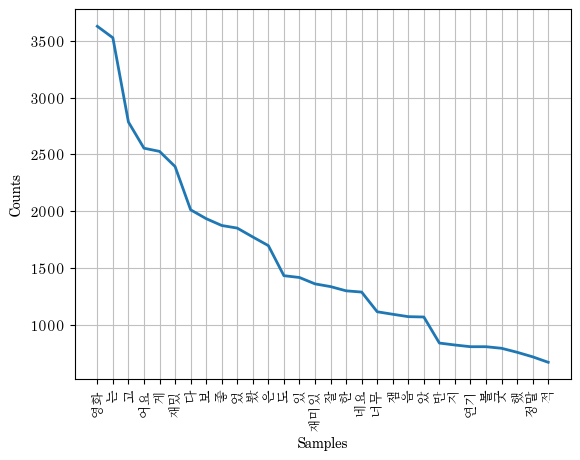

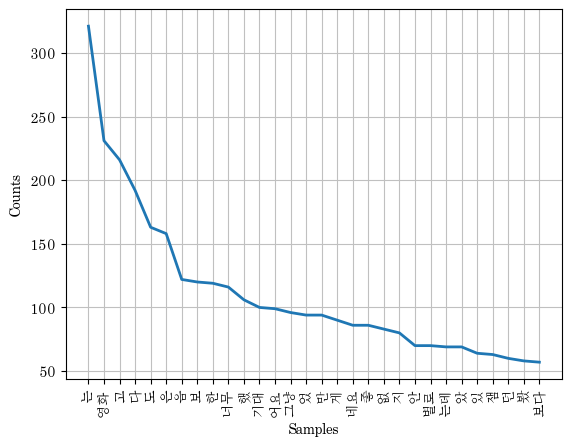

In [253]:
%matplotlib inline
import nltk
import matplotlib.pyplot as plt
pos = nltk.Text(p1_older_corpus)
neg = nltk.Text(n1_older_corpus)
plt.rcParams['font.family'] = 'AppleMyungjo'

plt.figure(1)
pos.plot(30)

plt.figure(2)
neg.plot(30)
plt.show()

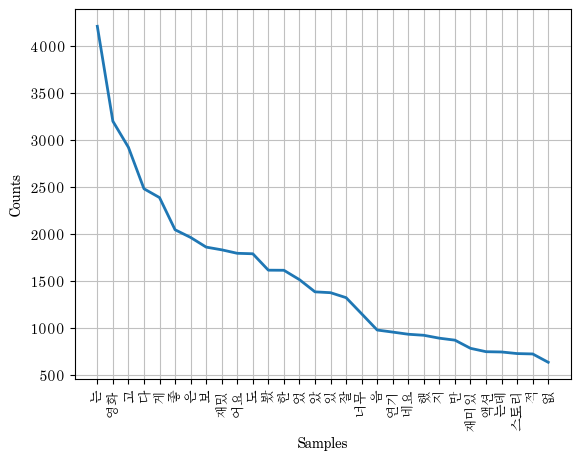

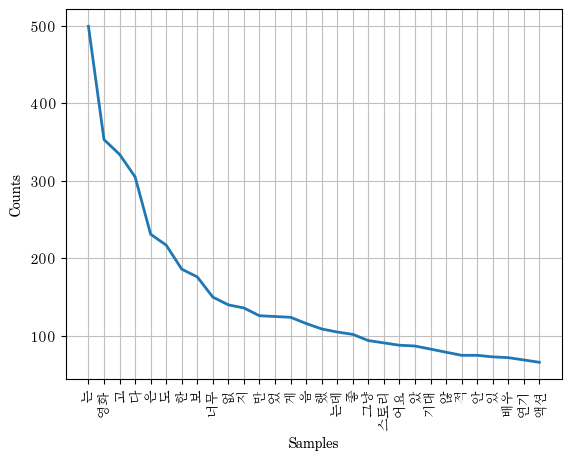

In [254]:
pos = nltk.Text(p1_newer_corpus)
neg = nltk.Text(n1_newer_corpus)
plt.rcParams['font.family'] = 'AppleMyungjo'

plt.figure(1)
pos.plot(30)

plt.figure(2)
neg.plot(30)
plt.show()

# 전체 텍스트 대상 tf-idf 구성

In [272]:
g_dictionary = gensim.corpora.Dictionary(older_tokens)
g_corpus = [g_dictionary.doc2bow(text) for text in older_tokens]
vector = CountVectorizer(vocabulary=g_dictionary.token2id)
older_dtm = vector.fit_transform(older_corpus).toarray()
col = g_dictionary.token2id.keys()
pd.DataFrame(older_dtm, columns=col)

,그냥,는,듯,뭐,보,애국심,인,재미,다,대단,...,탁하,이대로,일어난다는,실자,인긴,요년,모자이크,중심부,훑,븝놈든ㅇ신븝니ㅡ닌아삭하
0,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15197,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [273]:
tfidf_vectorizer = TfidfTransformer()
older_tf_idf = tfidf_vectorizer.fit_transform(older_dtm).toarray()
col = g_dictionary.token2id.keys()
print(older_tf_idf.shape)
pd.DataFrame(older_tf_idf, columns=col)

(15200, 8638)


,그냥,는,듯,뭐,보,애국심,인,재미,다,대단,...,탁하,이대로,일어난다는,실자,인긴,요년,모자이크,중심부,훑,븝놈든ㅇ신븝니ㅡ닌아삭하
0,0.47,0.00,0.00,0.00,0.00,0.77,0.00,0.43,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.52,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15195,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
15196,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
15197,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
15198,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [274]:
print(older_tf_idf)

[[0.4675929 0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]]


In [276]:
pd_older_tf_idf = pd.DataFrame(older_tf_idf, columns=col)
pd_older_tf_idf.sum().sort_values(ascending=False)[:40]

영화    797.67
어요    791.82
재밌    776.21
재미있   575.64
네요    414.16
너무    371.26
정말    283.68
연기    263.12
감동    251.32
입니다   248.91
재미    243.98
최고    228.65
기대    222.37
아요    191.96
ㅎㅎ    191.59
생각    178.97
는데    177.46
역시    168.81
그냥    167.33
합니다   161.91
배우    160.82
보다    160.09
ㅋㅋ    155.07
진짜    155.02
다시    128.75
스토리   119.95
추천    112.72
마블    110.30
지루    108.98
아주    106.09
괜찮     99.79
내용     97.95
완전     97.31
가족     94.95
역사     91.03
액션     87.25
세요     82.45
강동원    81.30
많이     79.76
나름     78.78
dtype: float64

In [277]:
g_dictionary = gensim.corpora.Dictionary(newer_tokens)
g_corpus = [g_dictionary.doc2bow(text) for text in newer_tokens]
vector = CountVectorizer(vocabulary=g_dictionary.token2id)
newer_dtm = vector.fit_transform(newer_corpus).toarray()
col = g_dictionary.token2id.keys()
pd.DataFrame(newer_dtm, columns=col)

,가볍,게,는,봤,생각,수,없이,영화,있,잘,...,예상외,타월,맡기,껀,쏟아져서,가해,견과,미과,액,된장
0,1,0,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [278]:
tfidf_vectorizer = TfidfTransformer()
newer_tf_idf = tfidf_vectorizer.fit_transform(newer_dtm).toarray()
col = g_dictionary.token2id.keys()
print(newer_tf_idf.shape)
pd.DataFrame(newer_tf_idf, columns=col)

(14005, 8867)


,가볍,게,는,봤,생각,수,없이,영화,있,잘,...,예상외,타월,맡기,껀,쏟아져서,가해,견과,미과,액,된장
0,0.51,0.00,0.00,0.00,0.36,0.00,0.45,0.21,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.38,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.19,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
14001,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
14002,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
14003,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.91


In [279]:
pd_newer_tf_idf = pd.DataFrame(newer_tf_idf, columns=col)
pd_newer_tf_idf.sum().sort_values(ascending=False)[:40]

영화    640.71
재밌    627.70
어요    570.04
재미있   350.37
너무    317.25
연기    272.26
네요    267.47
액션    220.31
최고    206.08
기대    204.24
스토리   193.80
는데    188.06
배우    176.85
보다    152.31
정말    150.60
감동    139.80
그냥    139.64
생각    139.10
마블    138.53
입니다   135.90
아요    126.24
재미    123.99
합니다   123.10
진짜    122.18
역시    114.64
시리즈   111.83
영상미   104.12
지루     97.65
연출     95.99
타임     88.58
관람     85.70
괜찮     84.24
느낌     75.92
ㅎㅎ     73.47
ㅋㅋ     72.22
해서     72.08
어서     71.95
킬링     71.22
아쉽     69.15
내용     68.96
dtype: float64

# 3.로지스틱 회귀에 의한 감정분석

In [282]:
older_movie_df['PN'].value_counts()

1    14127
0     1073
Name: PN, dtype: int64

In [283]:
newer_movie_df['PN'].value_counts()

1    12675
0     1330
Name: PN, dtype: int64

In [284]:
X = older_tf_idf
y = older_movie_df['PN']
older_data = pd.concat([y,pd.DataFrame(X)],axis = 1)

In [285]:
X = newer_tf_idf
y = newer_movie_df['PN']
newer_data = pd.concat([y,pd.DataFrame(X)],axis = 1)

In [286]:
from sklearn.model_selection import train_test_split

In [287]:
older_train_df,older_test_df = train_test_split(older_data, test_size = 0.2, random_state=256)
newer_train_df,newer_test_df = train_test_split(newer_data, test_size = 0.2, random_state=256)
older_train_df.head()

,PN,0,1,2,3,4,5,6,7,8,...,8628,8629,8630,8631,8632,8633,8634,8635,8636,8637
13440,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
12873,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1884,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7765,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
811,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [288]:
older_x_train = older_train_df.drop(['PN'], axis=1)
older_y_train = older_train_df['PN']
older_x_test = older_test_df.drop(['PN'], axis=1)
older_y_test = older_test_df['PN']

In [289]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [290]:
# fit in training set
older_lr = LogisticRegression(random_state = 0)
older_lr.fit(older_x_train,older_y_train)

# predict in test set
older_y_pred = older_lr.predict(older_x_test)

older_a1 = accuracy_score(older_y_test, older_y_pred)
older_p1 = precision_score(older_y_test, older_y_pred)
older_r1 =recall_score(older_y_test, older_y_pred)
older_f1= f1_score(older_y_test, older_y_pred)
print('accuracy: %.2f' % older_a1 )
print('precision: %.2f' % older_p1)
print('recall: %.2f' % older_r1)
print('F1: %.2f' % older_f1)

accuracy: 0.93
precision: 0.93
recall: 1.00
F1: 0.96


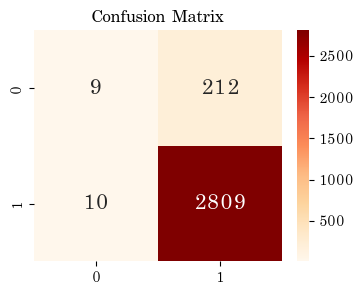

In [291]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confu = confusion_matrix(y_true = older_y_test, y_pred = older_y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.title('Confusion Matrix')
plt.show()

In [324]:
older_positive_random_idx = older_movie_df[older_movie_df['PN']==1].sample(1000, random_state=12).index.tolist()
older_negative_random_idx = older_movie_df[older_movie_df['PN']==0].sample(1000, random_state=12).index.tolist()

In [325]:
older_random_idx = older_positive_random_idx + older_negative_random_idx
x = older_tf_idf[older_random_idx]
y = older_movie_df['PN'][older_random_idx]
older_x_train2, older_x_test2, older_y_train2, older_y_test2 = train_test_split(x, y, test_size=0.2, random_state=1)

In [326]:
older_lr2 = LogisticRegression(random_state = 0)
older_lr2.fit(older_x_train2, older_y_train2)
older_y_pred2 = older_lr2.predict(older_x_test2)

In [327]:
# predict in test set
older_a2 = accuracy_score(older_y_test2, older_y_pred2)
older_p2 = precision_score(older_y_test2, older_y_pred2)
older_r2 = recall_score(older_y_test2, older_y_pred2)
older_f2 = f1_score(older_y_test2, older_y_pred2)
print('accuracy: %.2f' % older_a2 )
print('precision: %.2f' % older_p2)
print('recall: %.2f' % older_r2)
print('F1: %.2f' % older_f2)

accuracy: 0.72
precision: 0.74
recall: 0.67
F1: 0.70


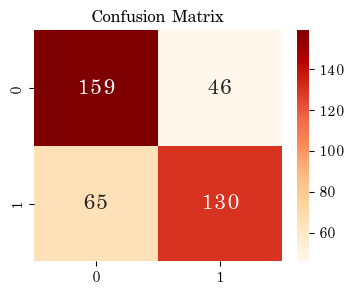

In [328]:
# 개선된 confusion matrix

from sklearn.metrics import confusion_matrix

confu = confusion_matrix(y_true = older_y_test2, y_pred = older_y_pred2)

plt.figure(figsize=(4, 3))
sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.title('Confusion Matrix')
plt.show()

In [329]:
pd.options.display.float_format = '{:.2f}'.format
tr1 = pd.DataFrame([older_a1,older_p1,older_r1,older_f1])
tr2 = pd.DataFrame([older_a2,older_p2,older_r2,older_f2])

test_result = pd.concat([tr1.T, tr2.T], axis=0)
test_result.columns=['Accuracy(정확도)', 'Precision(정밀도)', 'Recall(재현율)', 'F1']
test_result.index = ['1차 Imbalance Data', '2차 Under-sampling']
test_result

,Accuracy(정확도),Precision(정밀도),Recall(재현율),F1
1차 Imbalance Data,0.93,0.93,1.00,0.96
2차 Under-sampling,0.72,0.74,0.67,0.70


In [330]:
older_lr2.coef_

array([[-1.20864234,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

<BarContainer object of 8638 artists>

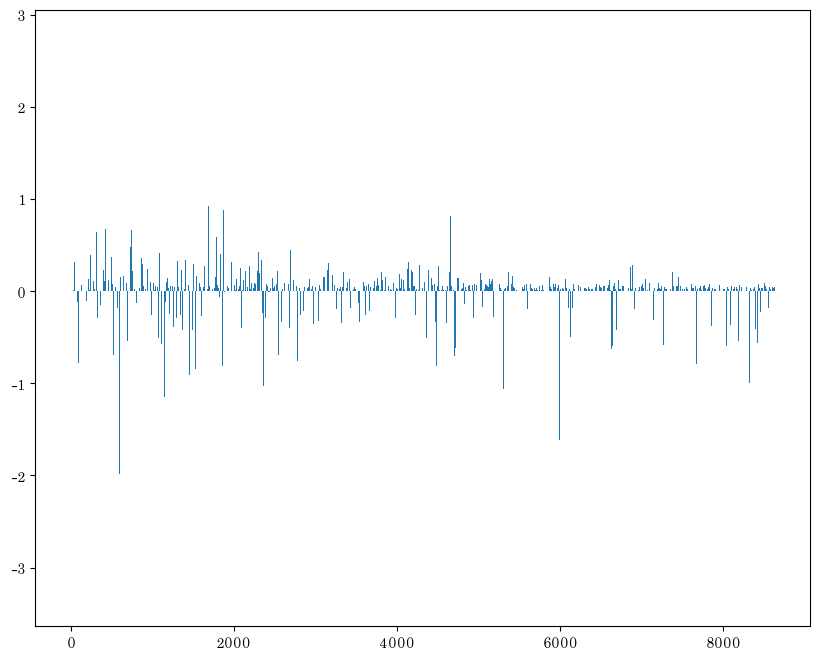

In [299]:
# print logistic regression's coef

plt.figure(figsize=(10, 8))
plt.bar(range(len(older_lr.coef_[0])), older_lr.coef_[0])

In [300]:
print(sorted(((value, index) for index, value in enumerate(older_lr.coef_[0])), reverse = True)[:5])
print(sorted(((value, index) for index, value in enumerate(older_lr.coef_[0])), reverse = True)[-5:])

[(2.7426283385552597, 31), (2.37964945863779, 177), (1.9394935562082831, 67), (1.512030575068025, 250), (1.468740868420581, 82)]
[(-2.3722555160764403, 566), (-2.9378928335042, 2634), (-3.2144614497886637, 1541), (-3.2837029441760595, 170), (-3.332252684028683, 654)]


In [331]:
older_coef_pos_index = sorted(((value, index) for index, value in enumerate(older_lr2.coef_[0])), reverse = True)
older_coef_neg_index = sorted(((value, index) for index, value in enumerate(older_lr2.coef_[0])), reverse = False)

In [332]:
invert_index_vectorizer = older_id_to_word

In [333]:
older_pos_top_word=[] 
older_pos_top_score=[]
for coef in older_coef_pos_index[:10]:
    print(invert_index_vectorizer[coef[1]], coef[0])
    older_pos_top_word.append(invert_index_vectorizer[coef[1]])
    older_pos_top_score.append(coef[0])

최고 1.8784131826021804
재미있 1.730126229251668
연기 1.5718025592798348
재밌 1.5133901507809837
봐야 1.4705761389308263
감동 1.4463615956784177
완전 1.4442674305302239
봐도 1.4130700894707453
역시 1.2853640976408094
그럭저럭 1.2402999170377165


In [334]:
older_neg_top_word=[] 
older_neg_top_score=[]
for coef in older_coef_neg_index[:10]:
    print(invert_index_vectorizer[coef[1]], coef[0])
    older_neg_top_word.append(invert_index_vectorizer[coef[1]])
    older_neg_top_score.append(coef[0])

별로 -2.4415784250687413
재미없 -2.204027682565422
실망 -2.1603604349743275
지루 -1.4558471822539594
그랬 -1.4312748970780889
뻔한 -1.211308313608663
건지 -1.2107515393450732
그냥 -1.2086423379502802
억지 -1.1959451263761811
별루 -1.1811740911450361


In [335]:
older_pos_top_word.reverse()
older_pos_top_score.reverse()
older_top_word=older_neg_top_word+ older_pos_top_word
older_top_score = older_neg_top_score+ older_pos_top_score

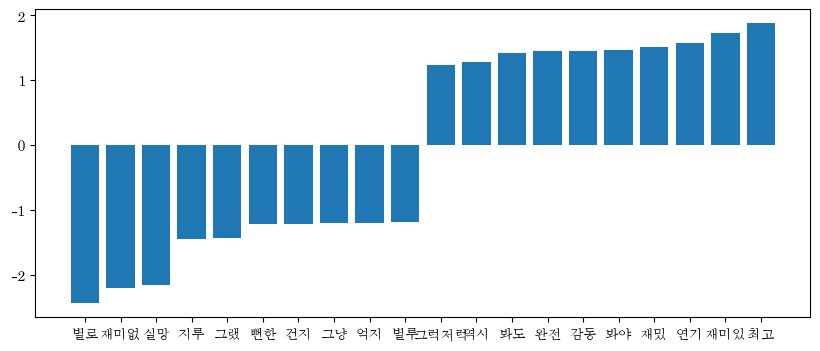

In [336]:
plt.figure(figsize=(10, 4))
plt.rcParams["axes.unicode_minus"] = False # 한글 폰트 사용시 - 깨지는 문제 해결

plt.bar(older_neg_top_word, older_neg_top_score, label = "부정", color = 'r')
plt.bar(older_pos_top_word, older_pos_top_score, label = "긍정", color = 'g')

plt.bar(range(len(older_top_score)), older_top_score)
plt.xticks(range(len(older_top_word)), older_top_word)
plt.show()

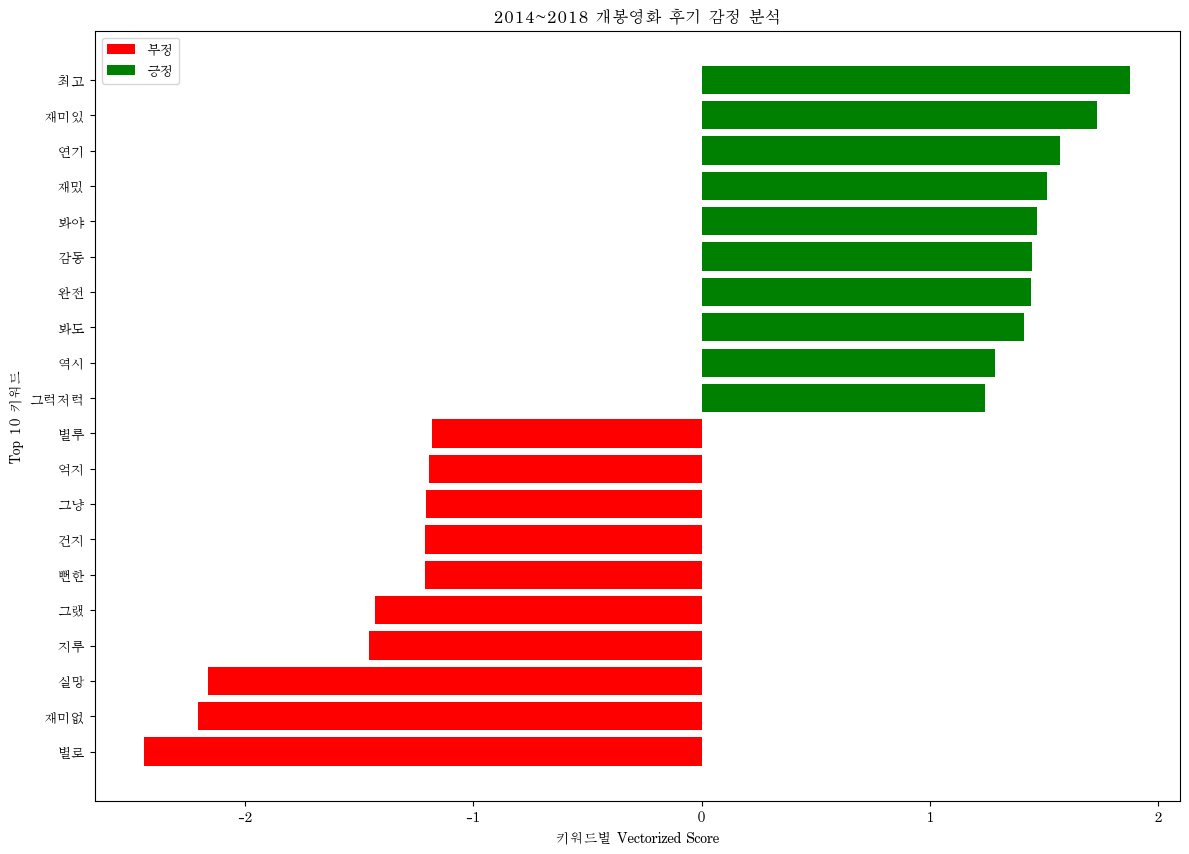

In [337]:
plt.figure(figsize=[14, 10])
plt.barh(older_neg_top_word, older_neg_top_score, label = "부정", color = 'r')
plt.barh(older_pos_top_word, older_pos_top_score, label = "긍정", color = 'g')
plt.legend()
plt.xlabel('키워드별 Vectorized Score')
plt.ylabel('Top 10 키워드')
# Giving the tilte for the plot
plt.title('2014~2018 개봉영화 후기 감정 분석')
# Saving the plot as a 'png'
plt.savefig('2BarPlot.png')
# Displaying the bar plot
plt.show()

In [308]:
newer_x_train = newer_train_df.drop(['PN'], axis=1)
newer_y_train = newer_train_df['PN']
newer_x_test = newer_test_df.drop(['PN'], axis=1)
newer_y_test = newer_test_df['PN']

In [309]:
# fit in training set
newer_lr = LogisticRegression(random_state = 0)
newer_lr.fit(newer_x_train,newer_y_train)

# predict in test set
newer_y_pred = newer_lr.predict(newer_x_test)

newer_a1 = accuracy_score(newer_y_test, newer_y_pred)
newer_p1 = precision_score(newer_y_test, newer_y_pred)
newer_r1 =recall_score(newer_y_test, newer_y_pred)
newer_f1= f1_score(newer_y_test, newer_y_pred)
print('accuracy: %.2f' % newer_a1)
print('precision: %.2f' % newer_p1)
print('recall: %.2f' % newer_r1)
print('F1: %.2f' % newer_f1)

accuracy: 0.90
precision: 0.90
recall: 1.00
F1: 0.95


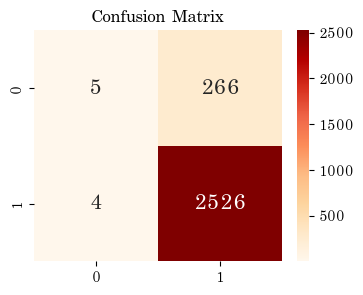

In [310]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confu = confusion_matrix(y_true = newer_y_test, y_pred = newer_y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.title('Confusion Matrix')
plt.show()

In [311]:
newer_positive_random_idx = newer_movie_df[newer_movie_df['PN']==1].sample(1000, random_state=12).index.tolist()
newer_negative_random_idx = newer_movie_df[newer_movie_df['PN']==0].sample(1000, random_state=12).index.tolist()

In [312]:
newer_random_idx = newer_positive_random_idx + newer_negative_random_idx
x = newer_tf_idf[newer_random_idx]
y = newer_movie_df['PN'][newer_random_idx]
newer_x_train2, newer_x_test2, newer_y_train2, newer_y_test2 = train_test_split(x, y, test_size=0.25, random_state=1)

In [313]:
newer_lr2 = LogisticRegression(random_state = 0)
newer_lr2.fit(newer_x_train2, newer_y_train2)
newer_y_pred2 = newer_lr2.predict(newer_x_test2)

In [314]:
# predict in test set
newer_a2 = accuracy_score(newer_y_test2, newer_y_pred2)
newer_p2 = precision_score(newer_y_test2, newer_y_pred2)
newer_r2 = recall_score(newer_y_test2,newer_y_pred2)
newer_f2 = f1_score(newer_y_test2, newer_y_pred2)
print('accuracy: %.2f' % newer_a2)
print('precision: %.2f' % newer_p2)
print('recall: %.2f' % newer_r2)
print('F1: %.2f' % newer_f2)

accuracy: 0.68
precision: 0.74
recall: 0.56
F1: 0.64


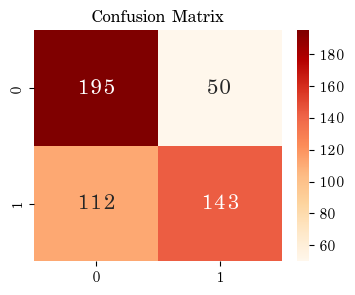

,Accuracy(정확도),Precision(정밀도),Recall(재현율),F1
1차 Imbalance Data,0.90,0.90,1.00,0.95
2차 Under-sampling,0.68,0.74,0.56,0.64


In [315]:
# 개선된 confusion matrix

from sklearn.metrics import confusion_matrix

confu = confusion_matrix(y_true = newer_y_test2, y_pred = newer_y_pred2)

plt.figure(figsize=(4, 3))
sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.title('Confusion Matrix')
plt.show()

pd.options.display.float_format = '{:.2f}'.format
tr1 = pd.DataFrame([newer_a1,newer_p1,newer_r1,newer_f1])
tr2 = pd.DataFrame([newer_a2,newer_p2,newer_r2,newer_f2])

test_result = pd.concat([tr1.T, tr2.T], axis=0)
test_result.columns=['Accuracy(정확도)', 'Precision(정밀도)', 'Recall(재현율)', 'F1']
test_result.index = ['1차 Imbalance Data', '2차 Under-sampling']
test_result

In [316]:
newer_lr.coef_

array([[ 0.05010721,  0.        ,  0.        , ...,  0.03159915,
         0.        , -0.71199372]])

[(2.7451966654217865, 206), (2.5194498524011917, 54), (2.4696733264019826, 13), (1.7946947195405705, 154), (1.6562151257051105, 997)]
[(-2.314359215065286, 2992), (-2.412234848704872, 814), (-2.5332835081750407, 241), (-3.3093955848910555, 302), (-3.841711704522241, 3075)]


[(-3.841711704522241, 3075),
 (-3.3093955848910555, 302),
 (-2.5332835081750407, 241),
 (-2.412234848704872, 814),
 (-2.314359215065286, 2992),
 (-2.1238594237134323, 3096),
 (-2.053285053481812, 253),
 (-2.0495053570096053, 2987),
 (-2.023819984727333, 180),
 (-2.014540934701633, 247)]

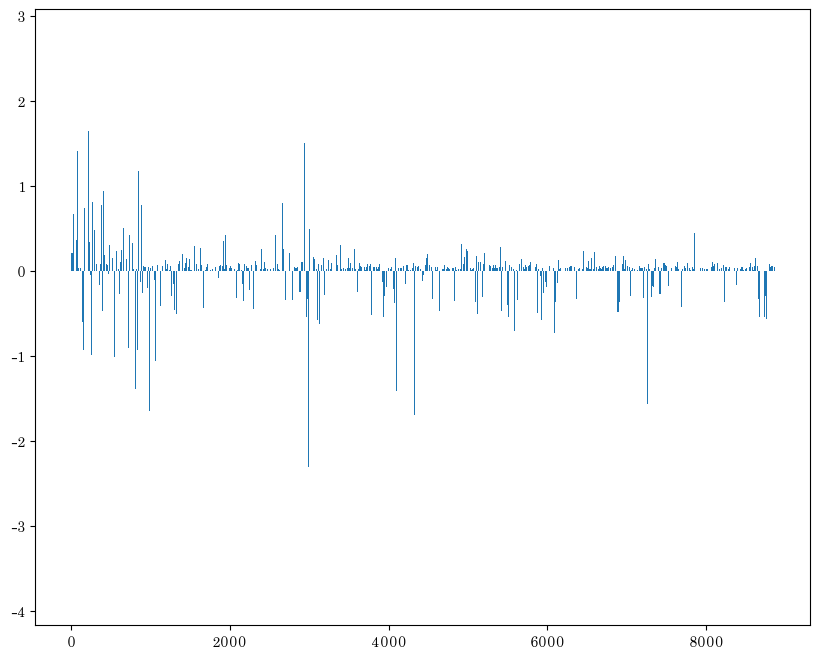

In [317]:
# print logistic regression's coef

plt.figure(figsize=(10, 8))
plt.bar(range(len(newer_lr.coef_[0])), newer_lr.coef_[0])

print(sorted(((value, index) for index, value in enumerate(newer_lr.coef_[0])), reverse = True)[:5])
print(sorted(((value, index) for index, value in enumerate(newer_lr.coef_[0])), reverse = True)[-5:])
# enumerate: 인덱스 번호와 컬렉션의 원소를 tuple형태로 반환함

newer_coef_pos_index = sorted(((value, index) for index, value in enumerate(newer_lr.coef_[0])), reverse = True)
newer_coef_neg_index = sorted(((value, index) for index, value in enumerate(newer_lr.coef_[0])), reverse = False)
newer_coef_pos_index[:10]
newer_coef_neg_index[:10]

In [318]:
# 일부 중요 원소들 단어사전 확인
print('긍정리뷰 키워드: ', newer_id_to_word[79],newer_id_to_word[92]) 
print('부정리뷰 키워드: ', newer_id_to_word[416],newer_id_to_word[513]) 

긍정리뷰 키워드:  주 중
부정리뷰 키워드:  주말 줄


In [319]:
invert_index_vectorizer = newer_id_to_word

newer_pos_top_word=[] 
newer_pos_top_score=[]
for coef in newer_coef_pos_index[:10]:
    print(invert_index_vectorizer[coef[1]], coef[0])
    newer_pos_top_word.append(invert_index_vectorizer[coef[1]])
    newer_pos_top_score.append(coef[0])

newer_neg_top_word=[] 
newer_neg_top_score=[]
for coef in newer_coef_neg_index[:10]:
    print(invert_index_vectorizer[coef[1]], coef[0])
    newer_neg_top_word.append(invert_index_vectorizer[coef[1]])
    newer_neg_top_score.append(coef[0])


최고 2.7451966654217865
재미있 2.5194498524011917
재밌 2.4696733264019826
부분 1.7946947195405705
괜찮 1.6562151257051105
감동 1.641501548696597
스파이더맨 1.5564831920974391
필요 1.4972965042577537
이정재 1.4969659155487245
영상미 1.4387968196873893
최악 -3.841711704522241
재미없 -3.3093955848910555
별로 -2.5332835081750407
실망 -2.412234848704872
그만 -2.314359215065286
건지 -2.1238594237134323
공감 -2.053285053481812
아까운 -2.0495053570096053
다가 -2.023819984727333
그냥 -2.014540934701633


In [320]:
newer_pos_top_word.reverse()
newer_pos_top_score.reverse()
newer_top_word=newer_neg_top_word+ newer_pos_top_word
newer_top_score = newer_neg_top_score+ newer_pos_top_score

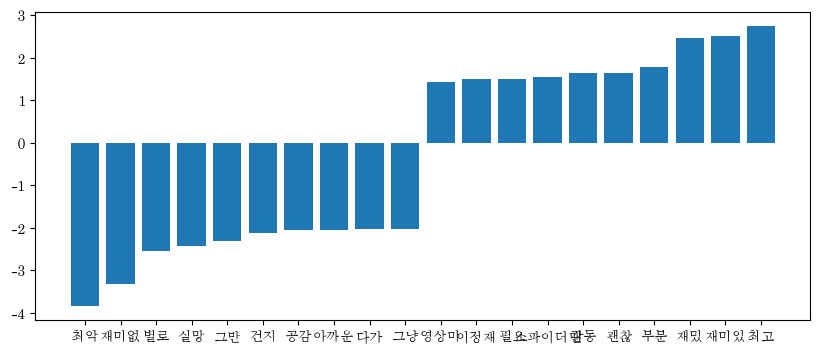

In [321]:
plt.figure(figsize=(10, 4))
plt.rcParams["axes.unicode_minus"] = False # 한글 폰트 사용시 - 깨지는 문제 해결

plt.bar(newer_neg_top_word, newer_neg_top_score, label = "부정", color = 'r')
plt.bar(newer_pos_top_word, newer_pos_top_score, label = "긍정", color = 'g')

plt.bar(range(len(newer_top_score)), newer_top_score)
plt.xticks(range(len(newer_top_word)), newer_top_word)
plt.show()

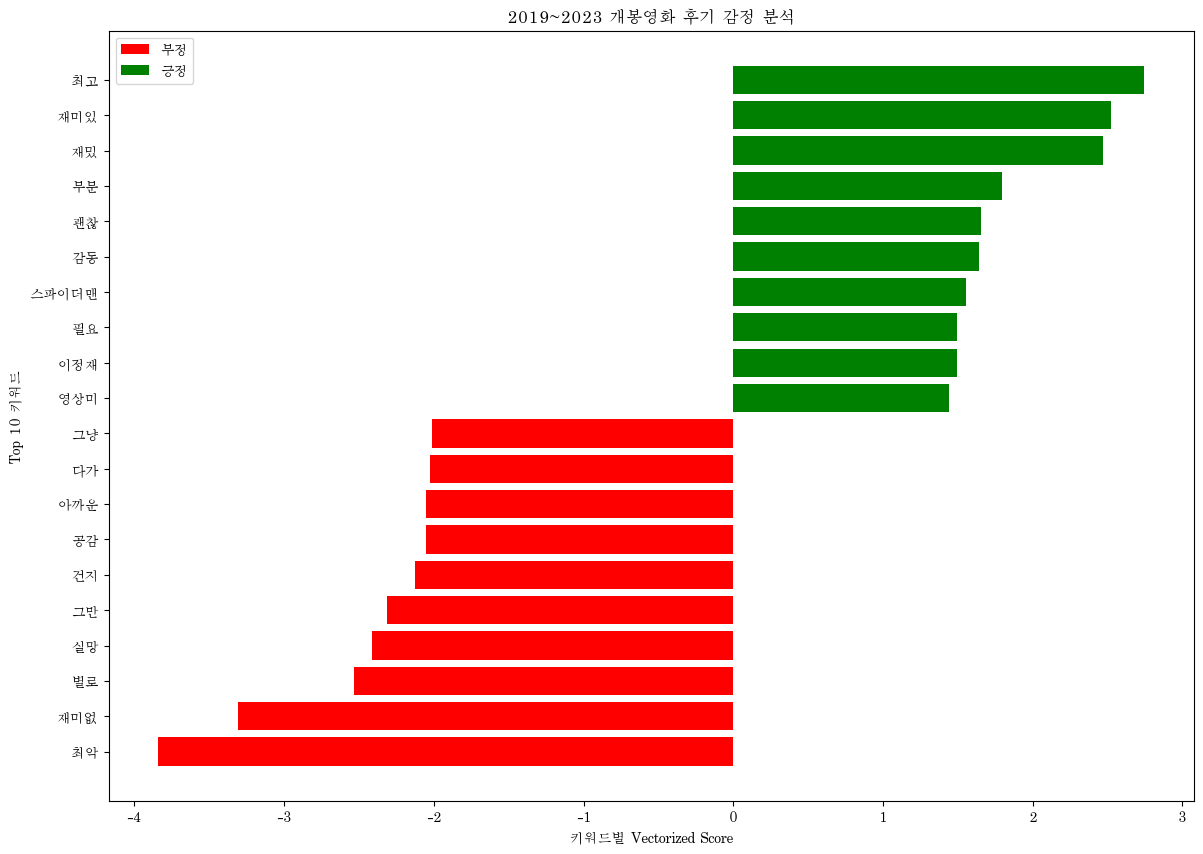

In [338]:
plt.figure(figsize=[14, 10])
plt.barh(newer_neg_top_word, newer_neg_top_score, label = "부정", color = 'r')
plt.barh(newer_pos_top_word, newer_pos_top_score, label = "긍정", color = 'g')
plt.legend()
plt.xlabel('키워드별 Vectorized Score')
plt.ylabel('Top 10 키워드')
# Giving the tilte for the plot
plt.title('2019~2023 개봉영화 후기 감정 분석')
# Saving the plot as a 'png'
plt.savefig('2BarPlot.png')
# Displaying the bar plot
plt.show()

# 모델별 크로스 검증
1. 구영화 훈련 > 신영화 검증
2. 신영화 훈련 > 구영화 검증
필요 작업: 각 test_set의 feature 개수 통일 

In [323]:
#cross체크용 회귀모델 재훈련
cross_older_lr = LogisticRegression(random_state = 0)
cross_older_lr.fit(older_x_train2, older_y_train2)
cross_older_y_pred = cross_older_lr.predict(newer_x_test2)

ValueError: X has 8867 features, but LogisticRegression is expecting 8638 features as input.

In [ ]:
cross_older_a1 = accuracy_score(newer_y_test2, cross_older_y_pred)
cross_older_p1 = precision_score(newer_y_test2, cross_older_y_pred)
cross_older_r1 = recall_score(newer_y_test2,cross_older_y_pred)
cross_older_f1 = f1_score(newer_y_test2, cross_older_y_pred)
print('accuracy: %.2f' % cross_older_a1)
print('precision: %.2f' % cross_older_p1)
print('recall: %.2f' % cross_older_r1)
print('F1: %.2f' % cross_older_f1)

In [ ]:
cross_newer_lr = LogisticRegression(random_state = 0)
cross_newer_lr.fit(newer_x_train, newer_y_train)
cross_newer_y_pred = cross_newer_lr.predict(older_x_test)